In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import yfinance as yf
import talib as ta

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
df = yf.download('TSLA', period='2d', interval='1m')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-23 09:30:00-05:00,1167.510010,1172.500000,1162.000000,1165.000000,1165.000000,933368
2021-11-23 09:31:00-05:00,1165.109985,1167.819946,1158.280029,1160.420044,1160.420044,182351
2021-11-23 09:32:00-05:00,1161.170044,1166.579956,1158.599976,1160.000000,1160.000000,128497
2021-11-23 09:33:00-05:00,1164.000000,1165.010010,1163.765259,1164.920044,1164.920044,113475
2021-11-23 09:34:00-05:00,1160.000000,1160.000000,1159.349976,1159.349976,1159.349976,109330
...,...,...,...,...,...,...
2021-11-24 15:56:00-05:00,1114.599976,1115.880005,1114.500000,1115.746338,1115.746338,63844
2021-11-24 15:57:00-05:00,1115.660034,1115.819946,1113.791992,1114.238037,1114.238037,84836
2021-11-24 15:58:00-05:00,1114.389771,1115.000000,1113.839966,1114.180054,1114.180054,66263


In [3]:
fig = go.Figure()

fig.add_trace(go.Candlestick(x=df.index, 
    open=df['Open'], 
    high=df['High'], 
    low=df['Low'], 
    close=df['Close'], 
    name="market data"
))
    
fig.update_layout(
    title="Tesla Price",
    yaxis_title="Stock Price (USD)"
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="30m", step="minute", stepmode="backward"),
            dict(count=6, label="90m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(step='all')
        ])
    )
)

fig.show()

In [4]:
df = df.drop(df[df['Volume'] == 0].index)
df

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-11-23 09:30:00-05:00,1167.510010,1172.500000,1162.000000,1165.000000,1165.000000,933368
2021-11-23 09:31:00-05:00,1165.109985,1167.819946,1158.280029,1160.420044,1160.420044,182351
2021-11-23 09:32:00-05:00,1161.170044,1166.579956,1158.599976,1160.000000,1160.000000,128497
2021-11-23 09:33:00-05:00,1164.000000,1165.010010,1163.765259,1164.920044,1164.920044,113475
2021-11-23 09:34:00-05:00,1160.000000,1160.000000,1159.349976,1159.349976,1159.349976,109330
...,...,...,...,...,...,...
2021-11-24 15:55:00-05:00,1115.180054,1115.592041,1114.479980,1114.849976,1114.849976,55346
2021-11-24 15:56:00-05:00,1114.599976,1115.880005,1114.500000,1115.746338,1115.746338,63844
2021-11-24 15:57:00-05:00,1115.660034,1115.819946,1113.791992,1114.238037,1114.238037,84836


In [5]:
n=10
df['RSI'] = ta.RSI(np.array(df['Close'].shift(1)), timeperiod=n)
df

,Open,High,Low,Close,Adj Close,Volume,RSI
Datetime,,,,,,,
2021-11-23 09:30:00-05:00,1167.510010,1172.500000,1162.000000,1165.000000,1165.000000,933368,NaN
2021-11-23 09:31:00-05:00,1165.109985,1167.819946,1158.280029,1160.420044,1160.420044,182351,NaN
2021-11-23 09:32:00-05:00,1161.170044,1166.579956,1158.599976,1160.000000,1160.000000,128497,NaN
2021-11-23 09:33:00-05:00,1164.000000,1165.010010,1163.765259,1164.920044,1164.920044,113475,NaN
2021-11-23 09:34:00-05:00,1160.000000,1160.000000,1159.349976,1159.349976,1159.349976,109330,NaN
...,...,...,...,...,...,...,...
2021-11-24 15:55:00-05:00,1115.180054,1115.592041,1114.479980,1114.849976,1114.849976,55346,42.863928
2021-11-24 15:56:00-05:00,1114.599976,1115.880005,1114.500000,1115.746338,1115.746338,63844,41.620862
2021-11-24 15:57:00-05:00,1115.660034,1115.819946,1113.791992,1114.238037,1114.238037,84836,46.318219


In [6]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, row_heights=[0.7, 0.3])

fig.add_trace(go.Candlestick(x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'], name = 'market data'),
    row=1, col=1
)

fig.update_xaxes(rangeslider_visible=False)

fig.add_trace(go.Scatter(x=df.index,
    y=df['RSI'] , 
    name = 'RSI', 
    line=dict(color='royalblue', 
    width=1.2)),
    row=2, 
    col=1
)

fig.show()

In [7]:
df['SMA'] = df['Close'].shift(1).rolling(window=n).mean()
df['Corr'] = df['Close'].shift(1).rolling(window=n).corr(df['SMA'].shift(1))

df['SAR'] = ta.SAR(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)), 0.2, 0.2)
df['ADX'] = ta.ADX(np.array(df['High'].shift(1)), np.array(df['Low'].shift(1)), np.array(df['Open']), timeperiod=n)

In [8]:
df['Prev_High'] = df['High'].shift(1)
df['Prev_Low'] = df['Low'].shift(1)
df['Prev_Close'] = df['Close'].shift(1)

In [9]:
df['OO']= df['Open'] - df['Open'].shift(1)
df['OC']= df['Open'] - df['Prev_Close']

In [10]:
df['Ret'] = (df['Open'].shift(-1)-df['Open'])/df['Open']

for i in range(1, n):
    df['return%i' % i] = df['Ret'].shift(i)

In [11]:
df.loc[df['Corr'] < -1, 'Corr'] = -1
df.loc[df['Corr'] > 1, 'Corr'] = 1

df = df.dropna()

In [12]:
t = 0.8
split = int(t*len(df))
split

606

In [13]:
import warnings
warnings.filterwarnings("ignore")

df['Signal'] = 0
df.loc[df['Ret'] > df['Ret'][:split].quantile(q=0.66), 'Signal'] = 1
df.loc[df['Ret'] < df['Ret'][:split].quantile(q=0.34), 'Signal'] = -1
df

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR,...,return1,return2,return3,return4,return5,return6,return7,return8,return9,Signal
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-23 09:50:00-05:00,1177.000000,1177.064941,1172.010132,1173.218750,1173.218750,97884,62.032722,1174.972278,0.702027,1173.761982,...,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0.000850,0.005988,-1
2021-11-23 09:51:00-05:00,1173.500000,1173.560059,1172.849976,1172.849976,1172.849976,65744,52.196017,1174.924951,0.556025,1180.449951,...,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0.000850,-1
2021-11-23 09:52:00-05:00,1172.000000,1172.446533,1171.000000,1172.446533,1172.446533,61459,51.495465,1175.002954,0.336296,1178.761987,...,-0.001278,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0
2021-11-23 09:53:00-05:00,1171.500000,1172.609985,1171.500000,1172.609985,1172.609985,46365,50.668814,1174.752612,0.280590,1177.411616,...,-0.000427,-0.001278,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,0
2021-11-23 09:54:00-05:00,1171.000000,1171.079956,1170.829956,1170.829956,1170.829956,54386,51.022742,1174.700623,0.148626,1176.129293,...,-0.000427,-0.000427,-0.001278,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24 15:54:00-05:00,1115.000000,1115.199951,1113.099976,1115.180054,1115.180054,76646,39.670413,1115.088843,0.318606,1112.400000,...,0.000074,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,-0.001786,-0.002560,0
2021-11-24 15:55:00-05:00,1115.180054,1115.592041,1114.479980,1114.849976,1114.849976,55346,42.863928,1114.601843,0.093209,1116.000000,...,0.000161,0.000074,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,-0.001786,0
2021-11-24 15:56:00-05:00,1114.599976,1115.880005,1114.500000,1115.746338,1115.746338,63844,41.620862,1114.355835,-0.404373,1113.099976,...,-0.000520,0.000161,0.000074,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,1


In [14]:
X = df.drop(['Close','Signal','High','Low','Volume','Ret'], axis=1)
y = df['Signal']

In [15]:
c = [10,100,1000,10000]
g = [1e-2,1e-1,1e0]

parameters = {'svc__C': c,
              'svc__gamma': g,
              'svc__kernel': ['rbf']
              }

steps = [('scaler', StandardScaler()), ('svc',SVC())]
pipeline = Pipeline(steps)

rcv = RandomizedSearchCV(pipeline, parameters, cv=TimeSeriesSplit(n_splits=2))

In [17]:
rcv.fit(X.iloc[:split], y.iloc[:split])

best_C = rcv.best_params_['svc__C']
best_gamma = rcv.best_params_['svc__gamma']
best_kernel = rcv.best_params_['svc__kernel']

In [18]:
cls = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

In [20]:
ss = StandardScaler()
cls.fit(ss.fit_transform(X.iloc[:split]), y.iloc[:split])

SVC(C=1000, gamma=0.01)

In [21]:
y_predict = cls.predict(ss.transform(X.iloc[split:]))

df['Pred_Signal'] = 0

In [22]:
y_predict

array([ 0, -1,  0,  1,  0,  1,  1,  0,  1,  0,  0,  0,  1,  1,  0,  0,  0,
        0,  0,  1,  0, -1,  0,  0, -1,  1,  0,  1,  0,  1,  0,  0,  0,  0,
        0,  1, -1, -1,  0,  0, -1, -1,  0, -1,  1,  0, -1,  0,  0,  0,  0,
        1,  0,  0,  0,  1,  1,  0,  0, -1,  1,  0,  0,  1,  0,  0,  0,  0,
        0,  1, -1,  1,  0,  0,  1,  1, -1, -1,  0,  0,  1,  0,  0,  0,  1,
        0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,
        1, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1,
        1, -1, -1, -1, -1,  1, -1,  0,  0, -1,  0,  0,  0,  1, -1,  0])

In [23]:
df.iloc[:split, df.columns.get_loc('Pred_Signal')] = pd.Series(cls.predict(ss.transform(X.iloc[:split])).tolist())
df.iloc[split:, df.columns.get_loc('Pred_Signal')] = y_predict

df

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR,...,return2,return3,return4,return5,return6,return7,return8,return9,Signal,Pred_Signal
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-23 09:50:00-05:00,1177.000000,1177.064941,1172.010132,1173.218750,1173.218750,97884,62.032722,1174.972278,0.702027,1173.761982,...,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0.000850,0.005988,-1,-1
2021-11-23 09:51:00-05:00,1173.500000,1173.560059,1172.849976,1172.849976,1172.849976,65744,52.196017,1174.924951,0.556025,1180.449951,...,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0.000850,-1,-1
2021-11-23 09:52:00-05:00,1172.000000,1172.446533,1171.000000,1172.446533,1172.446533,61459,51.495465,1175.002954,0.336296,1178.761987,...,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0,0
2021-11-23 09:53:00-05:00,1171.500000,1172.609985,1171.500000,1172.609985,1172.609985,46365,50.668814,1174.752612,0.280590,1177.411616,...,-0.001278,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,0,0
2021-11-23 09:54:00-05:00,1171.000000,1171.079956,1170.829956,1170.829956,1170.829956,54386,51.022742,1174.700623,0.148626,1176.129293,...,-0.000427,-0.001278,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24 15:54:00-05:00,1115.000000,1115.199951,1113.099976,1115.180054,1115.180054,76646,39.670413,1115.088843,0.318606,1112.400000,...,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,-0.001786,-0.002560,0,0
2021-11-24 15:55:00-05:00,1115.180054,1115.592041,1114.479980,1114.849976,1114.849976,55346,42.863928,1114.601843,0.093209,1116.000000,...,0.000074,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,-0.001786,0,0
2021-11-24 15:56:00-05:00,1114.599976,1115.880005,1114.500000,1115.746338,1115.746338,63844,41.620862,1114.355835,-0.404373,1113.099976,...,0.000161,0.000074,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,1,1


In [24]:
df['Ret1'] = df['Ret']*df['Pred_Signal']
df

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,Corr,SAR,...,return3,return4,return5,return6,return7,return8,return9,Signal,Pred_Signal,Ret1
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-11-23 09:50:00-05:00,1177.000000,1177.064941,1172.010132,1173.218750,1173.218750,97884,62.032722,1174.972278,0.702027,1173.761982,...,-0.000212,0.001063,0.005128,0.000000,-0.005947,0.000850,0.005988,-1,-1,0.002974
2021-11-23 09:51:00-05:00,1173.500000,1173.560059,1172.849976,1172.849976,1172.849976,65744,52.196017,1174.924951,0.556025,1180.449951,...,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0.000850,-1,-1,0.001278
2021-11-23 09:52:00-05:00,1172.000000,1172.446533,1171.000000,1172.446533,1172.446533,61459,51.495465,1175.002954,0.336296,1178.761987,...,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,-0.005947,0,0,-0.000000
2021-11-23 09:53:00-05:00,1171.500000,1172.609985,1171.500000,1172.609985,1172.609985,46365,50.668814,1174.752612,0.280590,1177.411616,...,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,0.000000,0,0,-0.000000
2021-11-23 09:54:00-05:00,1171.000000,1171.079956,1170.829956,1170.829956,1170.829956,54386,51.022742,1174.700623,0.148626,1176.129293,...,-0.001278,-0.002974,-0.000212,0.000212,-0.000212,0.001063,0.005128,1,1,0.000854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24 15:54:00-05:00,1115.000000,1115.199951,1113.099976,1115.180054,1115.180054,76646,39.670413,1115.088843,0.318606,1112.400000,...,0.000556,0.000664,-0.000634,0.001945,-0.002647,-0.001786,-0.002560,0,0,0.000000
2021-11-24 15:55:00-05:00,1115.180054,1115.592041,1114.479980,1114.849976,1114.849976,55346,42.863928,1114.601843,0.093209,1116.000000,...,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,-0.001786,0,0,-0.000000
2021-11-24 15:56:00-05:00,1114.599976,1115.880005,1114.500000,1115.746338,1115.746338,63844,41.620862,1114.355835,-0.404373,1113.099976,...,0.000074,-0.000154,0.000556,0.000664,-0.000634,0.001945,-0.002647,1,1,0.000951


In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index[split:], y= (df['Ret'][split:]+1).cumprod(),line=dict(color='royalblue', width=.8), name = 'stock_returns'))
fig.add_trace(go.Scatter(x=df.index[split:], y= (df['Ret1'][split:]+1).cumprod(),line=dict(color='orange', width=.8), name = 'strategy_returns'))

fig.update_layout(
    title='Support Vector Machine Strategy',
    yaxis_title='Stock return (% Return)')

fig.show()

In [26]:
cm = confusion_matrix(y[split:], y_predict)
cm

array([[18, 18,  0],
       [ 9, 54, 13],
       [ 1, 15, 24]])

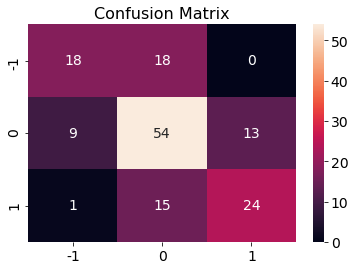

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted labels', fontsize=14)
plt.ylabel('True labels', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams.update({'font.size': 14})

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.xaxis.set_ticklabels(['-1', '0', '1'])
ax.yaxis.set_ticklabels(['-1', '0', '1'])
plt.show()

In [28]:
cr = classification_report(y[split:], y_predict)
print(cr)

              precision    recall  f1-score   support

          -1       0.64      0.50      0.56        36
           0       0.62      0.71      0.66        76
           1       0.65      0.60      0.62        40

    accuracy                           0.63       152
   macro avg       0.64      0.60      0.62       152
weighted avg       0.63      0.63      0.63       152

